# Machine learning (ML) models comparison

In the following notebook we compare the performance of the trained single-fidelity GP, multi-fidelity GP, and neural network models.

We begin by importing the necessary modules.

In [1]:
from IPython.display import clear_output

In [2]:
!pip install brokenaxes
clear_output()

In [150]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from numpy.random import random
from matplotlib import colors as mcolors
from brokenaxes import brokenaxes
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
%matplotlib inline

np.random.seed(20)

In [4]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

Next, we import the high fidelity testing dataset, which is composed of 100 samples.

In [5]:
!wget https://raw.githubusercontent.com/josebarahonay/prueba/master/testing_input_data_100_hf.npy
!wget https://raw.githubusercontent.com/josebarahonay/prueba/master/testing_output_data_100_hf.npy

clear_output()

In [6]:
# Load the testing dataset
X_hf_100 = np.load('testing_input_data_100_hf.npy')
Y_hf_100 = np.load('testing_output_data_100_hf.npy')

print("Testing X HF size :", X_hf_100.shape)
print("Testing Y HF size :", Y_hf_100.shape)

Testing X HF size : (100, 6)
Testing Y HF size : (100, 2)


Then, we import the respiratory-system compliance (`C`) and airways resistance(`R`) predictions of our trained single-fidelity GP (`sfGP`), multi-fidelity GP (`mfGP`), and neural network (`NN`) models.

In [7]:
!wget https://raw.githubusercontent.com/josebarahonay/datos_org/master/NN_C.npy
!wget https://raw.githubusercontent.com/josebarahonay/datos_org/master/NN_R.npy
!wget https://raw.githubusercontent.com/josebarahonay/datos_org/master/sfGP_C.npy
!wget https://raw.githubusercontent.com/josebarahonay/datos_org/master/sfGP_R.npy
!wget https://raw.githubusercontent.com/josebarahonay/datos_org/master/mfGP_C.npy
!wget https://raw.githubusercontent.com/josebarahonay/datos_org/master/mfGP_R.npy
!wget https://raw.githubusercontent.com/josebarahonay/datos_org/master/sfGP_var_R.npy
!wget https://raw.githubusercontent.com/josebarahonay/datos_org/master/sfGP_var_C.npy
!wget https://raw.githubusercontent.com/josebarahonay/datos_org/master/mfgp_var_R.npy
!wget https://raw.githubusercontent.com/josebarahonay/datos_org/master/mfgp_var_C.npy

clear_output()

And make some array adjustments in order to be adequately ploted,

In [8]:
NN_C = np.squeeze(np.load('NN_C.npy'))
NN_R = np.squeeze(np.load('NN_R.npy'))

gp_C = np.squeeze(np.load('sfGP_C.npy'))
gp_R = np.squeeze(np.load('sfGP_R.npy'))

mfgp_C = np.squeeze(np.load('mfGP_C.npy'))
mfgp_R = np.squeeze(np.load('mfGP_R.npy'))

lf_C = mfgp_C[:100]
hf_C = mfgp_C[100:]
lf_R = mfgp_R[:100]
hf_R = mfgp_R[100:]

gp_std_C = np.squeeze(np.sqrt(np.load('sfGP_var_C.npy')))
gp_std_R = np.squeeze(np.sqrt(np.load('sfGP_var_R.npy')))

mfgp_std_C = np.squeeze(np.sqrt(np.load('mfgp_var_C.npy')))
mfgp_std_R = np.squeeze(np.sqrt(np.load('mfgp_var_R.npy')))

sfgp_array_c = np.concatenate([np.expand_dims(Y_hf_100[:,1], axis=1), np.expand_dims(gp_C, axis=1), np.expand_dims(gp_std_C, axis=1)], axis = 1)
sfgp_array_c = sfgp_array_c[sfgp_array_c[:, 0].argsort()]

sfgp_array_r = np.concatenate([np.expand_dims(Y_hf_100[:,0], axis=1), np.expand_dims(gp_R, axis=1), np.expand_dims(gp_std_R, axis=1)], axis = 1)
sfgp_array_r = sfgp_array_r[sfgp_array_r[:, 0].argsort()]

mfgp_array_c = np.concatenate([np.expand_dims(Y_hf_100[:,1], axis=1), np.expand_dims(hf_C, axis=1), np.expand_dims(mfgp_std_C[100:], axis=1)], axis = 1)
mfgp_array_c = mfgp_array_c[mfgp_array_c[:, 0].argsort()]

mfgp_array_r = np.concatenate([np.expand_dims(Y_hf_100[:,0], axis=1), np.expand_dims(hf_R, axis=1), np.expand_dims(mfgp_std_R[100:], axis=1)], axis = 1)
mfgp_array_r = mfgp_array_r[mfgp_array_r[:, 0].argsort()]

In [152]:
cmap_2 = plt.cm.get_cmap('GnBu')

rgba_4 = cmap_2(0.99)
rgba_5 = cmap_2(0.7)
rgba_6 = cmap_2(0.75)

<ipython-input-152-0124ba55b3c2>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_2 = plt.cm.get_cmap('GnBu')


#### Useful plotting functions

In [51]:
# Bland-Altman

def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    CI_low    = md - 1.96*sd
    CI_high   = md + 1.96*sd

    #plt.figure(figsize=(3.2,3.2))
    #plt.scatter(mean, diff, *args, **kwargs, marker='x', color = rgba_6)
    #plt.axhline(md,           color='k', linestyle='-', label = 'Mean')
    #plt.axhline(md + 1.96*sd, color='k', linestyle='--', label = u"\u00B1"'1.96SD')
    #plt.axhline(md - 1.96*sd, color='k', linestyle='--')

    return md, sd, mean, CI_low, CI_high, mean, diff

def bland_altman_broken(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    CI_low    = md - 1.96*sd
    CI_high   = md + 1.96*sd

    fig, ((ax1,ax2,ax3)) = plt.subplots(nrows=3, ncols=1, sharex = True, gridspec_kw={'height_ratios': [1, 2.3, 1]})
    fig.set_size_inches(3.8, 3.8)
    fig.subplots_adjust(hspace=0.07)  # adjust space between axes
    ax1.scatter(mean, diff, *args, **kwargs, marker='x', color = rgba_6)
    ax1.axhline(md,           color='k', linestyle='-')
    ax1.axhline(md + 1.96*sd, color='k', linestyle='--')
    ax1.axhline(md - 1.96*sd, color='k', linestyle='--')
    ax2.scatter(mean, diff, *args, **kwargs, marker='x', color = rgba_6)
    ax2.axhline(md,           color='k', linestyle='-')
    ax2.axhline(md + 1.96*sd, color='k', linestyle='--')
    ax2.axhline(md - 1.96*sd, color='k', linestyle='--')
    ax3.scatter(mean, diff, *args, **kwargs, marker='x', color = rgba_6)
    ax3.axhline(md,           color='k', linestyle='-')
    ax3.axhline(md + 1.96*sd, color='k', linestyle='--')
    ax3.axhline(md - 1.96*sd, color='k', linestyle='--')
    ax1.set_ylim(0.3*4, 1.3*4)
    ax2.set_ylim(-0.13*4,0.13*4)
    ax3.set_ylim(-1.3*4, -0.3*4)
    ax3.set_xlim(2.2,7.5)
    # hide the spines between ax1 and ax3
    ax1.spines['bottom'].set_visible(True)
    ax1.spines['bottom'].set_alpha(0.2)
    ax2.spines['top'].set_visible(True)
    ax2.spines['top'].set_alpha(0.2)
    ax2.spines['bottom'].set_visible(True)
    ax2.spines['bottom'].set_alpha(0.2)
    ax3.spines['top'].set_visible(True)
    ax3.spines['top'].set_alpha(0.2)
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop=False, top = False)  # don't put tick labels at the top
    ax2.tick_params(labelbottom=False, bottom = False)  # don't put tick labels at the top
    ax3.xaxis.tick_bottom()
    # Broken-axis lines
    d = .015
     # Upside
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +3*d), **kwargs, linewidth=1)        # top-left diagonal
    ax1.plot((1 - d, 1 + d), (-d, +3*d), **kwargs, linewidth=1)  # top-right diagonal
    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs, linewidth=1)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs, linewidth=1)  # bottom-right diagonal
     # Downside
    kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False)
    ax2.plot((-d, +d), (-d, +d), **kwargs, linewidth=1)        # top-left diagonal
    ax2.plot((1 - d, 1 + d), (-d, +d), **kwargs, linewidth=1)  # top-right diagonal
    kwargs.update(transform=ax3.transAxes)  # switch to the bottom axes
    ax3.plot((-d, +d), (1 - 3*d, 1 + d), **kwargs, linewidth=1)  # bottom-left diagonal
    ax3.plot((1 - d, 1 + d), (1 - 3*d, 1 + d), **kwargs, linewidth=1)  # bottom-right diagonal
    # Additional plot configuration
    ax1.set_yticks(np.linspace(3.5,3.5,1))
    ax2.set_yticks(np.linspace(-0.4,0.4,3))
    ax3.set_yticks(np.linspace(-3.5,-3.5,1))
    ax3.set_xticks(np.linspace(2.8, 7, 3))

    ax3.tick_params(axis='x', labelsize=12)
    ax1.tick_params(axis='y', labelsize=12)
    ax2.tick_params(axis='y', labelsize=12)
    ax3.tick_params(axis='y', labelsize=12)
    ax3.set_xlabel("Means", size=12, labelpad=10)

    fig.text(-0.08, 0.4, "Difference", rotation='vertical', size = 12)

    return md, sd, mean, CI_low, CI_high

## Respiratory-system compliance predictions: correlation plots

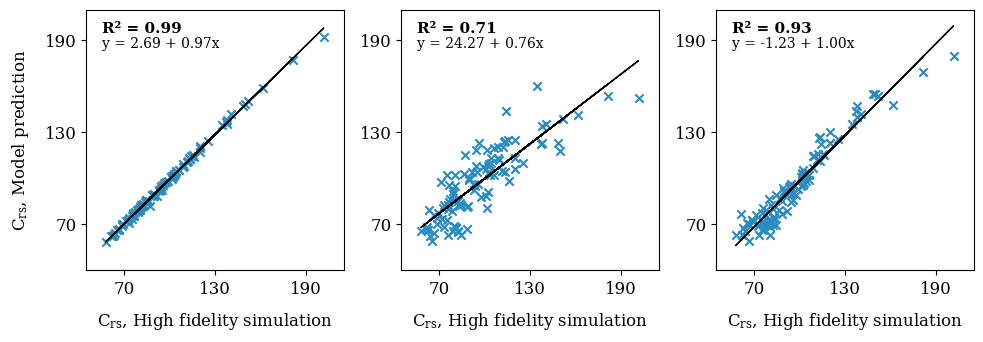

In [159]:
# Compliance predictions plot

fig, axs = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(3.2*3, 3.2)
fig.tight_layout()

axs = axs.ravel()

ML_pred = [hf_C, gp_C, NN_C] # mfGP, sfGP, and NN compliance predictions

for i in range(len(ML_pred)):
    axs[i].scatter(Y_hf_100[:,1], ML_pred[i], color = rgba_6, marker = 'x')
    axs[i].set_xlabel('$\mathregular{C_{rs}}$, High fidelity simulation',size = 12,labelpad=10)
    if i == 0:
        axs[i].set_ylabel('$\mathregular{C_{rs}}$, Model prediction',size = 12, color = 'k',labelpad=10)
    a2, b2 = np.polyfit(Y_hf_100[:,1], ML_pred[i],1)
    axs[i].plot(Y_hf_100[:,1], a2*Y_hf_100[:,1] + b2, color = 'k', linewidth = 1)
    axs[i].text(55, 185, 'y = ' + '{:.2f}'.format(b2) + ' + {:.2f}'.format(a2) + 'x', size=10)
    minor_ticks_left=np.linspace(70,190,3)
    axs[i].set_yticks(minor_ticks_left)
    axs[i].set_xticks(minor_ticks_left)
    axs[i].set_xlim(45,215)
    axs[i].set_ylim(40,210)
    axs[i].tick_params(axis='x', labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)
    r2_c = R2(Y_hf_100[:,1], ML_pred[i])
    if r2_c > 0.99:
        axs[i].annotate("R² = {:.2f}".format(0.99),(55,195),size = 11,weight='bold')
    else:
        axs[i].annotate("R² = {:.2f}".format(r2_c),(55,195),size = 11,weight='bold')
plt.savefig("r2_c.png", dpi=600, bbox_inches='tight')
plt.show()

## Airways resistance predictions: correlation plots

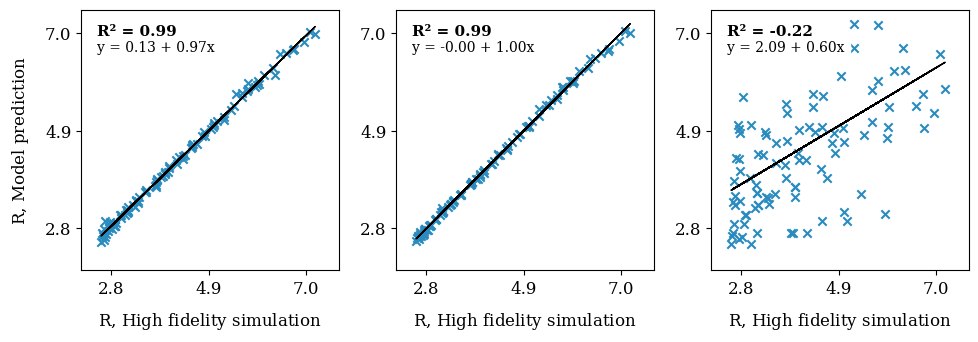

In [160]:
# Resistance predictions plot

fig, axs = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(3.2*3, 3.2)
fig.tight_layout()

axs = axs.ravel()

ML_pred = [hf_R, gp_R, NN_R] # mfGP, sfGP, and NN resistance predictions

for i in range(len(ML_pred)):
    axs[i].scatter(Y_hf_100[:,0], ML_pred[i], color = rgba_6, marker = 'x')
    axs[i].set_xlabel('$\mathregular{R}$, High fidelity simulation',size = 12,labelpad=10)
    if i == 0:
        axs[i].set_ylabel('$\mathregular{R}$, Model prediction',size = 12, color = 'k',labelpad=10)
    a2, b2 = np.polyfit(Y_hf_100[:,0], ML_pred[i],1)
    axs[i].plot(Y_hf_100[:,0], a2*Y_hf_100[:,0] + b2, color = 'k', linewidth = 1)
    axs[i].text(2.5, 6.6, 'y = ' + '{:.2f}'.format(b2) + ' + {:.2f}'.format(a2) + 'x', size=10, backgroundcolor='white',alpha=1)
    minor_ticks_left=np.linspace(2.8,7,3)
    axs[i].set_yticks(minor_ticks_left)
    axs[i].set_xticks(minor_ticks_left)
    axs[i].set_xlim(2.15,7.7)
    axs[i].set_ylim(1.9,7.5)
    axs[i].tick_params(axis='x', labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)
    r2_r = R2(Y_hf_100[:,0], ML_pred[i])
    if r2_r > 0.99:
        axs[i].annotate("R² = {:.2f}".format(0.99),(2.5,6.95),size = 11,weight='bold')
    else:
        axs[i].annotate("R² = {:.2f}".format(r2_r),(2.5,6.95),size = 11,weight='bold')

plt.savefig("r2_r.png", dpi=600, bbox_inches='tight')
plt.show()

## Respiratory-system compliance predictions: Bland-Altman plots

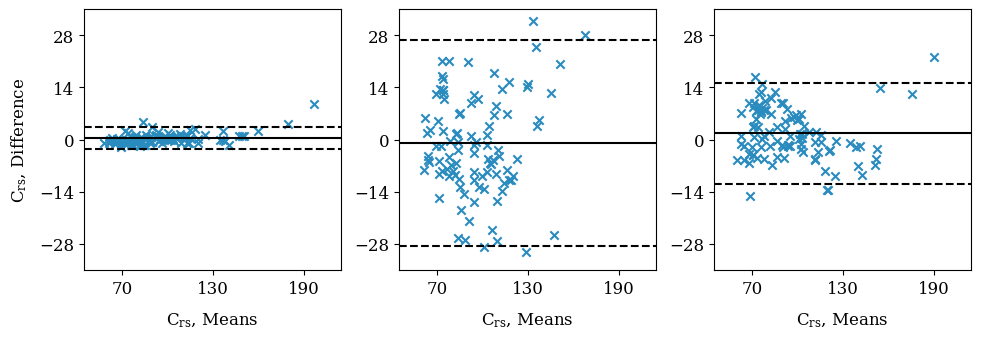

In [54]:
# Compliance Bland-Altman plot

fig, axs = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(3.2*3, 3.2)
fig.tight_layout()

axs = axs.ravel()

ML_pred = [hf_C, gp_C, NN_C] # mfGP, sfGP, and NN resistance predictions

for i in range(len(ML_pred)):
    md, sd, mean, CI_low, CI_high, mean, diff = bland_altman_plot(Y_hf_100[:,1], ML_pred[i])
    axs[i].scatter(mean, diff, marker='x', color = rgba_6)
    axs[i].axhline(md,           color='k', linestyle='-', label = 'Mean')
    axs[i].axhline(md + 1.96*sd, color='k', linestyle='--', label = u"\u00B1"'1.96SD')
    axs[i].axhline(md - 1.96*sd, color='k', linestyle='--')
    axs[i].set_xlabel("$\mathregular{C_{rs}}$, Means", size=12, labelpad=10)
    if i == 0:
        axs[i].set_ylabel("$\mathregular{C_{rs}}$, Difference", size=12, color='k', labelpad=7)
    axs[i].set_yticks(np.linspace(-28,28,5))
    axs[i].set_xticks(np.linspace(70,190,3))
    axs[i].set_xlim(45,215)
    axs[i].set_ylim(-35,35)
    axs[i].tick_params(axis='x', labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)

plt.savefig("blandaltman_c.png", dpi=600, bbox_inches='tight')
plt.show()

## Airways resistance predictions: Bland-Altman plots

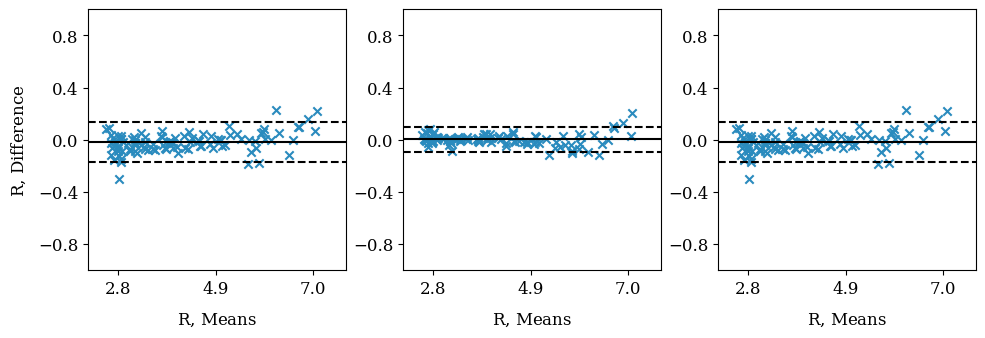

In [56]:
# Resistance Bland-Altman plot

fig, axs = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(3.2*3, 3.2)
fig.tight_layout()

axs = axs.ravel()

ML_pred = [hf_R, gp_R, hf_R] # mfGP, sfGP, and NN resistance predictions

for i in range(len(ML_pred)):
    md, sd, mean, CI_low, CI_high, mean, diff = bland_altman_plot(Y_hf_100[:,0], ML_pred[i])
    axs[i].scatter(mean, diff, marker='x', color = rgba_6)
    axs[i].axhline(md,           color='k', linestyle='-', label = 'Mean')
    axs[i].axhline(md + 1.96*sd, color='k', linestyle='--', label = u"\u00B1"'1.96SD')
    axs[i].axhline(md - 1.96*sd, color='k', linestyle='--')
    axs[i].set_xlabel("$\mathregular{R}$, Means", size=12, labelpad=10)
    if i == 0:
        axs[i].set_ylabel("$\mathregular{R}$, Difference", size=12, color='k', labelpad=7)
    axs[i].set_yticks(np.linspace(-0.2*4,0.2*4,5))
    axs[i].set_xticks(np.linspace(2.8,7,3))
    axs[i].set_xlim(2.15,7.7)
    axs[i].set_ylim(-1,1)
    axs[i].tick_params(axis='x', labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)

plt.savefig("blandaltman_r.png", dpi=600, bbox_inches='tight')
plt.show()

** For simplicity, the Bland-Altman plot of NN predictions is plotted in a different cell.

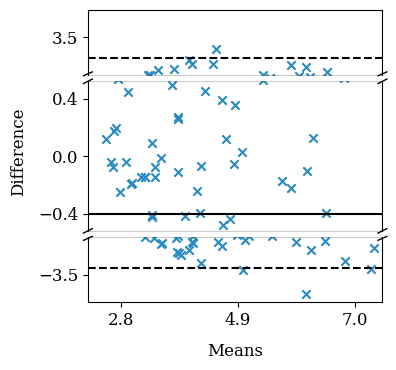

In [57]:
# NN
md, sd, mean, CI_low, CI_high = bland_altman_broken(Y_hf_100[:,0], NN_R)
plt.savefig("blandaltman_nn_r.png", dpi=600, bbox_inches='tight')
plt.show()

## ML models performance v/s training size

In [59]:
!wget https://raw.githubusercontent.com/josebarahonay/datos_org/master/RMSE_R_mfGP.npy
!wget https://raw.githubusercontent.com/josebarahonay/datos_org/master/RMSE_C_mfGP.npy
!wget https://raw.githubusercontent.com/josebarahonay/datos_org/master/std_R_mfGP.npy
!wget https://raw.githubusercontent.com/josebarahonay/datos_org/master/std_C_mfGP.npy

!wget https://raw.githubusercontent.com/josebarahonay/datos_org/master/RMSE_R_sfGP.npy
!wget https://raw.githubusercontent.com/josebarahonay/datos_org/master/RMSE_C_sfGP.npy
!wget https://raw.githubusercontent.com/josebarahonay/datos_org/master/std_R_sfGP.npy
!wget https://raw.githubusercontent.com/josebarahonay/datos_org/master/std_C_sfGP.npy

!wget https://raw.githubusercontent.com/josebarahonay/datos_org/master/RMSE_R_1_NN.npy
!wget https://raw.githubusercontent.com/josebarahonay/datos_org/master/RMSE_C_1_NN.npy
!wget https://raw.githubusercontent.com/josebarahonay/datos_org/master/std_R_1_NN.npy
!wget https://raw.githubusercontent.com/josebarahonay/datos_org/master/std_C_1_NN.npy
!wget https://raw.githubusercontent.com/josebarahonay/datos_org/master/RMSE_R_2_NN.npy
!wget https://raw.githubusercontent.com/josebarahonay/datos_org/master/RMSE_C_2_NN.npy
!wget https://raw.githubusercontent.com/josebarahonay/datos_org/master/std_R_2_NN.npy
!wget https://raw.githubusercontent.com/josebarahonay/datos_org/master/std_C_2_NN.npy

clear_output()

In [66]:
RMSE_R_mfgp = np.load('RMSE_R_mfGP.npy')
RMSE_C_mfgp= np.load('RMSE_C_mfGP.npy')
std_R_mfgp = np.load('std_R_mfGP.npy')
std_C_mfgp = np.load('std_C_mfGP.npy')

RMSE_R_sfgp = np.load('RMSE_R_sfGP.npy')
RMSE_C_sfgp= np.load('RMSE_C_sfgp.npy')
std_R_sfgp = np.load('std_R_sfGP.npy')
std_C_sfgp = np.load('std_C_sfGP.npy')

RMSE_R_1_nn = np.load('RMSE_R_1_NN.npy')
RMSE_C_1_nn= np.load('RMSE_C_1_NN.npy')
std_R_1_nn = np.load('std_R_1_NN.npy')
std_C_1_nn = np.load('std_C_1_NN.npy')
RMSE_R_2_nn = np.load('RMSE_R_2_NN.npy')
RMSE_C_2_nn= np.load('RMSE_C_2_NN.npy')
std_R_2_nn = np.load('std_R_2_NN.npy')
std_C_2_nn = np.load('std_C_2_NN.npy')
RMSE_R_nn = np.concatenate((RMSE_R_1_nn, RMSE_R_2_nn), axis=0)
RMSE_C_nn = np.concatenate((RMSE_C_1_nn, RMSE_C_2_nn), axis=0)
std_R_nn = np.concatenate((std_R_1_nn, std_R_2_nn), axis=0)
std_C_nn = np.concatenate((std_C_1_nn, std_C_2_nn), axis=0)

In [67]:
cmap_2 = plt.cm.get_cmap('GnBu')

rgba_4 = cmap_2(0.99)
rgba_5 = cmap_2(0.75)
rgba_6 = cmap_2(0.5)

<ipython-input-67-51c61d7889ea>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_2 = plt.cm.get_cmap('GnBu')


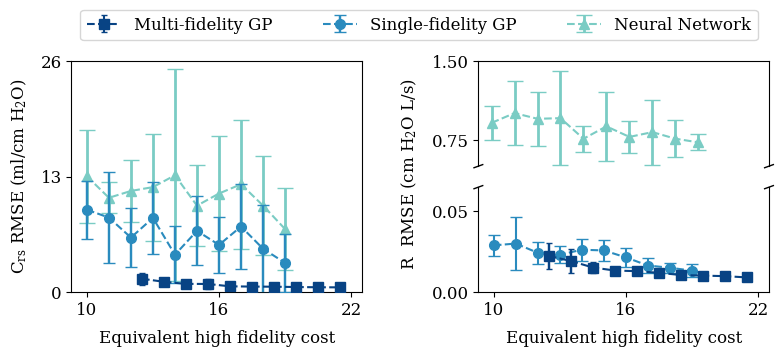

<Figure size 640x480 with 0 Axes>

In [148]:
fig = plt.figure()
fig.set_size_inches(4.5*2, 3)
fig.tight_layout()

ax1 = plt.subplot2grid(shape=(2, 2), loc=(0, 0), rowspan=2)
ax2 = plt.subplot2grid(shape=(2, 2), loc=(0, 1), colspan=1)
ax3 = plt.subplot2grid(shape=(2, 2), loc=(1, 1), colspan=2)

ax1.errorbar(np.arange(10+(200/80),20+(200/80)),RMSE_C_mfgp, np.asarray(std_C_mfgp), linestyle='dashed', elinewidth=1.5, marker = 's', markersize = 7, capsize = 2, label = 'Multi-fidelity GP', color = rgba_4, zorder = 10)
ax1.errorbar(np.arange(10,20),RMSE_C_sfgp, np.asarray(std_C_sfgp), linestyle='dashed', elinewidth=1.75, marker = 'o', markersize = 7, capsize = 4, label = 'Single-fidelity GP', color = rgba_5, zorder = 5)
ax1.errorbar(np.arange(10,20),RMSE_C_nn, np.asarray(std_C_nn), linestyle='dashed', elinewidth=2, marker = '^', markersize = 7, capsize = 6, capthick=1, label = 'Neural Network', color = rgba_6, zorder = 0)
ax1.set_xticks(np.linspace(10,22,3))
ax1.set_yticks(np.linspace(0,26,3))
ax1.set_xlim(9.3,20+(200/80))
ax1.set_ylim(0,26)
ax1.set_ylabel("$\mathregular{C_{rs}}$ RMSE (ml/cm $\mathregular{H_2O}$)", size = 12, labelpad = 8)
ax1.set_xlabel('Equivalent high fidelity cost', size = 12, labelpad = 8)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)

ax2.errorbar(np.arange(10+(200/80),20+(200/80)),RMSE_R_mfgp, np.asarray(std_R_mfgp), linestyle='dashed', elinewidth=1.5, marker = 's', markersize = 7, capsize = 2, color = rgba_4, zorder = 10)
ax2.errorbar(np.arange(10,20),RMSE_R_sfgp, np.asarray(std_R_sfgp), linestyle='dashed', elinewidth=1.75, marker = 'o', markersize = 7, capsize = 4, color = rgba_5, zorder = 5)
ax2.errorbar(np.arange(10,20),RMSE_R_nn, np.asarray(std_R_nn), linestyle='dashed', elinewidth=2, marker = '^', markersize = 7, capsize = 6, color = rgba_6, zorder = 0)
ax3.errorbar(np.arange(10+(200/80),20+(200/80)),RMSE_R_mfgp, np.asarray(std_R_mfgp), linestyle='dashed', elinewidth=1.75, marker = 's', markersize = 7, capsize = 2, color = rgba_4, zorder = 10)
ax3.errorbar(np.arange(10,20),RMSE_R_sfgp, np.asarray(std_R_sfgp), linestyle='dashed', elinewidth=1.5, marker = 'o', markersize = 7, capsize = 4, color = rgba_5, zorder = 5)
ax3.errorbar(np.arange(10,20),RMSE_R_nn, np.asarray(std_R_nn), linestyle='dashed', elinewidth=2, marker = '^', markersize = 7, capsize = 6, color = rgba_6, zorder = 0)

ax3.set_xticks(np.linspace(10,22,3))
ax2.set_yticks(np.linspace(.75,1.5,2))
ax3.set_yticks(np.linspace(0,.05,2))
ax3.set_xlim(9.3,20+(200/80))
ax2.set_ylim(0.5, 1.5)
ax3.set_ylim(0,0.065)
#fig.supylabel("$\mathregular{R}$  RMSE" "\n" "(cm $H_20$ L/s)", size = 12)
fig.text(0.49, 0.2, "$\mathregular{R}$  RMSE (cm $\mathregular{H_2O}$ L/s)", rotation='vertical', size = 12)
ax3.set_xlabel('Equivalent high fidelity cost', size = 12, labelpad = 8)
ax3.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax3.tick_params(axis='y', labelsize=12)

# hide the spines between ax and ax3
ax2.spines['bottom'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax2.xaxis.tick_top()
ax2.tick_params(labeltop=False, top = False)  # don't put tick labels at the top
ax3.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False)
ax2.plot((-d, +d), (-d, +d), **kwargs, linewidth=1)        # top-left diagonal
ax2.plot((1 - d, 1 + d), (-d, +d), **kwargs, linewidth=1)  # top-right diagonal

kwargs.update(transform=ax3.transAxes)  # switch to the bottom axes
ax3.plot((-d, +d), (1 - d, 1 + d), **kwargs, linewidth=1)  # bottom-left diagonal
ax3.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs, linewidth=1)  # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax3 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'
fig.legend(bbox_to_anchor=(0.135, 0.95, 0.7525, 0.1), loc="lower left", ncol=3, fancybox = True, mode ='expand', borderaxespad=0, fontsize=12)

plt.subplots_adjust(wspace=0.4)
plt.show()
plt.draw()

fig.savefig("rmse.png", bbox_inches='tight', dpi=600)